In [1]:
import sys
sys.path.insert(0, '../preprocessing')
import preprocessing as pre

import numpy as np
import pandas as pd
from keras import layers, models
from keras import regularizers
from keras.layers.normalization import BatchNormalization

/Users/jinli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train,
 X_valid, y_valid,
 X_test, y_test) = pre.train_validate_test(r'../data/planesnet.json')

Size of Train Set is: 20480
Size of Validation Set is: 5120
Size of Test Set is: 6400


In [3]:
X_train_s = pre.scale (X_train, scale='constant')
train_images = X_train_s.reshape([-1,3,20,20]).transpose([0,2,3,1])
print (train_images.dtype, '\n',
       train_images.shape)

float32 
 (20480, 20, 20, 3)


In [4]:
X_valid_s = pre.scale (X_valid, scale='constant')
valid_images = X_valid_s.reshape([-1,3,20,20]).transpose([0,2,3,1])
print (valid_images.dtype, '\n',
       valid_images.shape)

float32 
 (5120, 20, 20, 3)


In [5]:
X_test_s = pre.scale (X_test, scale='constant')
test_images = X_test_s.reshape([-1,3,20,20]).transpose([0,2,3,1])
print (test_images.dtype, '\n',
       test_images.shape)

float32 
 (6400, 20, 20, 3)


In [6]:
from keras.utils import to_categorical

train_labels = to_categorical(y_train)
valid_labels = to_categorical(y_valid)
test_labels = to_categorical(y_test)

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), 
                        activation='relu', 
                        input_shape=(20,20,3)) )

#model.add(layers.SeparableConv2D(32, 3,
#                                 activation='relu', 
#                                 input_shape=(20,20,3)))

model.add(layers.MaxPooling2D((2,2)))

model.add(BatchNormalization())

model.add(layers.Conv2D(64, (1,1),
                        activation='relu'))

#model.add(layers.SeparableConv2D(64, 1,
#                                 activation='relu', ))

model.add(layers.Conv2D(64, (3,3),
                        activation='relu'))

#model.add(layers.SeparableConv2D(64, 3,
#                                 activation='relu', ))


model.add(BatchNormalization())

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (2,2), 
                        activation='relu'))
#model.add(layers.SeparableConv2D(128, 2,
#                                 activation='relu', ))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())

#model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(64, 
                       kernel_regularizer=regularizers.l2(0.001),
                       activation='relu', )
                      )
model.add(layers.Dropout(.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          2112      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    # we don't want to shift or scale the image
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True)

batch_size = 100
epochs = 30
training_set = train_datagen.flow(train_images, train_labels, batch_size=batch_size)

valid_datagen = ImageDataGenerator()
valid_set = valid_datagen.flow(valid_images, valid_labels, batch_size=batch_size)

#training_set

In [9]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, \
                            EarlyStopping, ReduceLROnPlateau

weight_path="CNN_2/{}_weights.best.hdf5".format('CNN2')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay) # can place this in call_backs_list

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=5)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [10]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
#history = model.fit(train_images, train_labels,
#          epochs=epochs,
#          batch_size=batch_size,
#          validation_data=(valid_images, valid_labels))
#len(train_images)
#round (len(train_images) / batch_size)

In [11]:
history2 = model.fit_generator(training_set,
                               validation_data=valid_set,
                               steps_per_epoch= round (len(train_images) / batch_size),
                               epochs=epochs,
                               validation_steps=round (len(valid_images) / batch_size),
                               callbacks=callbacks_list)

Epoch 1/30
205/205 [==============================] - 23s 113ms/step - loss: 0.2456 - acc: 0.9303 - val_loss: 1.5853 - val_acc: 0.6867

Epoch 00001: val_loss improved from inf to 1.58534, saving model to CNN_2/CNN2_weights.best.hdf5
Epoch 2/30
205/205 [==============================] - 22s 108ms/step - loss: 0.1469 - acc: 0.9612 - val_loss: 0.2825 - val_acc: 0.9066

Epoch 00002: val_loss improved from 1.58534 to 0.28248, saving model to CNN_2/CNN2_weights.best.hdf5
Epoch 3/30
205/205 [==============================] - 20s 97ms/step - loss: 0.1166 - acc: 0.9686 - val_loss: 0.7807 - val_acc: 0.7863

Epoch 00003: val_loss did not improve from 0.28248

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/30
205/205 [==============================] - 18s 90ms/step - loss: 0.0869 - acc: 0.9784 - val_loss: 0.0792 - val_acc: 0.9793

Epoch 00004: val_loss improved from 0.28248 to 0.07921, saving model to CNN_2/CNN2_weights.best.hdf5
Epoch 5/30
205/205 [======

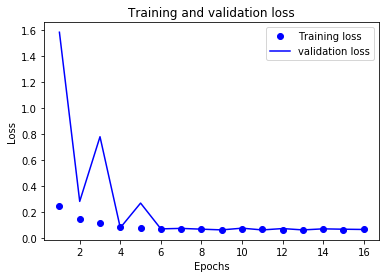

In [12]:
import matplotlib.pyplot as plt
history_dict = history2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot (epochs, loss_values, 'bo', label='Training loss')
plt.plot (epochs, val_loss_values, 'b', label="validation loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

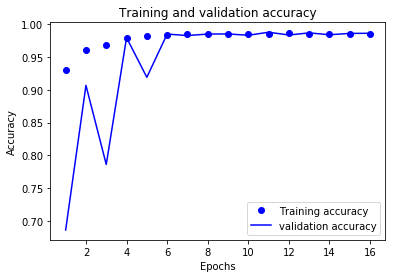

In [13]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot (epochs, acc, 'bo', label='Training accuracy')
plt.plot (epochs, val_acc, 'b', label="validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
model.evaluate(test_images, test_labels)

6400/6400 [==============================] - 2s 254us/step


[0.10611832418479025, 0.96546875]